<a href="https://colab.research.google.com/github/maverick98/Coursera/blob/master/intent_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!cp /content/drive/MyDrive/question_intent.csv /content

**Install Cohere**

In [109]:
!pip install -qq install cohere
!pip -qq install catboost
import cohere
api_key='kA7wifgPmqS8QFQJ2hl01DSKOJdjOv7oPdw9WN6r'
co = cohere.Client(api_key)

**Import Libraries**

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,RepeatedStratifiedKFold,cross_val_score,GridSearchCV#HalvingGridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, metrics, cv
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

**Load Dataset**

In [112]:

df = pd.read_csv('question_intent.csv',names=['query','intent'])
df.columns = df.iloc[0]
df = df[1:]
df.head()

,query,intent
1,How many products were sold in January?:,Get Data
2,What's the total revenue for the year 2023?:,Get Data
3,How many new customers did we acquire last qua...,Get Data
4,What's the average revenue per product?:,Get Data
5,How many items are in stock?:,Get Data


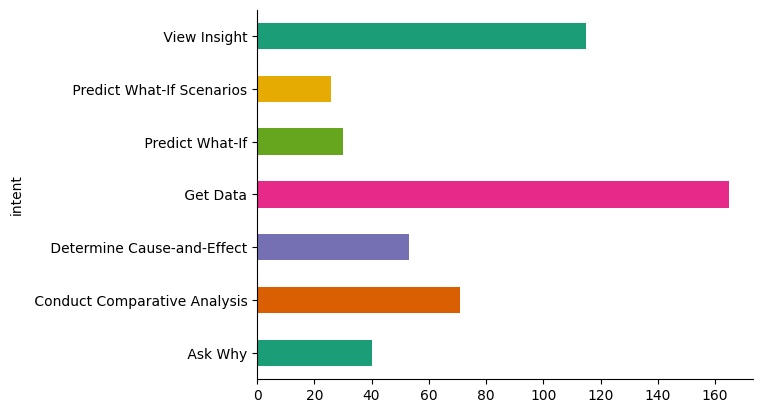

In [113]:
# @title intent

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('intent').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [114]:
# Get embeddings
def embed_text(text):
  output = co.embed(
                model='embed-english-v3.0',
                input_type="classification",
                texts=text)
  return output.embeddings
def embed(X):
    X_embed = np.array(embed_text(X.tolist()))
    return X_embed
def label_encoder(y):
    le = preprocessing.LabelEncoder()
    le.fit(y)
    return le


In [115]:
X, y = df["query"], df["intent"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Embed and prepare the inputs
X_train_embed = embed(X_train)
X_test_embed = embed(X_test)


# Prepare the labels
le = label_encoder(y_train)
y_train_le = le.transform(y_train)
y_test_le = le.transform(y_test)


In [161]:
def predict_report(model,model_desc,print_details=False):
    y_pred = model.predict(X_test_embed)
    accuracy = accuracy_score(y_test_le, y_pred)
    precision = precision_score(y_test_le, y_pred,average='weighted')
    recall = recall_score(y_test_le, y_pred,average='weighted')
    f1 = f1_score(y_test_le, y_pred,average='weighted')
    print('{} f1 score {}'.format(model_desc,f1))
    if print_details is True:

        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")
        print(classification_report(y_test_le, y_pred))
    return float(f1)

def predict(model,X_embed):
    y_pred = model.predict(X_embed)
    pred = list(le.inverse_transform(y_pred))
    return pred
def embed_question(question):
    return embed_text([question])
def get_intent(model,question):
    return predict(model,embed_question(question))[0]
def build_svm_model():
    svm_clf=SVC(kernel = 'linear', C = 1,class_weight='balanced').fit(X_train_embed, y_train_le)
    return svm_clf
def build_naive_bayes_model():
    gnb_classifier=GaussianNB()
    gnb_classifier.fit(X_train_embed, y_train_le)
    return gnb_classifier
def build_vanilla_logistic_model( ):
    logistic_model = LogisticRegression()
    logistic_model.fit(X_train_embed, y_train_le)
    return logistic_model
def build_balanced_logistic_model():
    logistic_model = LogisticRegression(solver='newton-cg', class_weight='balanced')
    logistic_model.fit(X_train_embed, y_train_le )
    return logistic_model
def build_vainlla_decision_tree_model( ):
    decision_tree_model = DecisionTreeClassifier()
    decision_tree_model.fit(X_train_embed, y_train_le)
    return decision_tree_model
def build_decision_tree_model( ):
    decision_tree_model = DecisionTreeClassifier(max_depth =16, min_samples_leaf =1, min_samples_split = 2, random_state=42)
    decision_tree_model.fit(X_train_embed, y_train_le)
    return decision_tree_model
def build_balanced_decision_tree_model( ):
    decision_tree_model = DecisionTreeClassifier(class_weight='balanced',max_depth =16, min_samples_leaf =1, min_samples_split = 2, random_state=42)
    decision_tree_model.fit(X_train_embed, y_train_le)
    return decision_tree_model
def build_knn_model():
    knn_clf = KNN()
    knn_clf.fit(X_train_embed, y_train_le)
    return knn_clf
def build_svm_model():
    svm_clf = SVC(probability= True)
    svm_clf.fit(X_train_embed, y_train_le)
    return svm_clf
def build_naive_bayes_model():
    gnb_classifier=GaussianNB()
    gnb_classifier.fit(X_train_embed, y_train_le)
    return gnb_classifier

def build_random_forest_classifier():
    rf_clf = RandomForestClassifier(n_estimators=300,
                                max_leaf_nodes=16,
                                random_state= 42
                                )
    rf_clf.fit(X_train_embed, y_train_le)
    return rf_clf
def build_balanced_bagging_classifier():
    balanced_bagging_classifier = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='not majority',
                                replacement=False,
                                random_state=42)
    balanced_bagging_classifier.fit(X_train_embed, y_train_le)
    return balanced_bagging_classifier
def build_adaboost_model():
    ada_boost_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),
                         n_estimators=125,
                         learning_rate = 0.6,
                         random_state=42)

    ada_boost_clf.fit(X_train_embed, y_train_le)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

    n_scores = cross_val_score(ada_boost_clf, X_train_embed, y_train_le, scoring='f1_weighted', cv=cv, n_jobs=-1, error_score='raise')
    ('Accuracy: %.3f' % (np.mean(n_scores)*100))
    return ada_boost_clf

def build_catboost_model():
    cat_boost_clf = CatBoostClassifier(iterations=5,learning_rate=0.1)
    cat_boost_clf.fit(X_train_embed, y_train_le,eval_set = (X_test_embed, y_test_le),verbose = False)
    return cat_boost_clf
def build_xgboost_model():
    xg_boost_clf = XGBClassifier(learning_rate=0.1,)
    xg_boost_clf.fit(X_train_embed, y_train_le,eval_set = [(X_train_embed, y_train_le), (X_test_embed, y_test_le)],verbose = False)
    return xg_boost_clf
def build_libgbm_model():
    libgbm_clf = LGBMClassifier(learning_rate = 0.1)
    libgbm_clf.fit(X_train_embed, y_train_le,eval_set = [(X_train_embed, y_train_le), (X_test_embed, y_test_le)])
    return libgbm_clf


In [158]:
def find_best_model(model_details):
    best_model=None
    best_model_desc=None
    best_f1=negative_infinity = float('-inf')
    for model_detail in model_details:
        model_desc=model_detail[1]
        model=model_detail[0]
        f1=predict_report(model,model_desc)

        if f1 > best_f1:
            best_f1=f1
            best_model=model
            best_model_desc=model_desc
    return  best_model,best_model_desc,best_f1


In [162]:
model_details=[]

model = build_svm_model()
model_desc='Support Vector Machine'
model_details.append((model,model_desc))



model = build_naive_bayes_model()
model_desc='Gaussian Naive Bayes'
model_details.append((model,model_desc))


model = build_vanilla_logistic_model()
model_desc='Logistic Regression'
model_details.append((model,model_desc))

model = build_knn_model()
model_desc='Logistic Regression'
model_details.append((model,model_desc))


model=build_libgbm_model()
model_desc='libgbm'
model_details.append((model,model_desc))

model=build_catboost_model()
model_desc='CatBoost'
model_details.append((model,model_desc))

model=build_xgboost_model()
model_desc='XGBoost'
model_details.append((model,model_desc))

best_model,best_model_desc,best_f1=find_best_model(model_details)
print('best model is {} with f1={}'.format(best_model_desc,best_f1))
print(get_intent(best_model,'How much hike I will get this year?'))

#print(f'Accuracy: {100*accuracy:.2f}')
#print(f'F1-score: {100*f1:.2f}')





[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136998
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 1024
[LightGBM] [Info] Start training from score -2.494957
[LightGBM] [Info] Start training from score -1.948413
[LightGBM] [Info] Start training from score -2.162823
[LightGBM] [Info] Start training from score -1.131652
[LightGBM] [Info] Start training from score -2.695628
[LightGBM] [Info] Start training from score -3.158251
[LightGBM] [Info] Start training from score -1.480605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further